# Mitigating Disparities in Ranking from Binary Data
_**An example based on the Law School Admissions Council's National Longitudinal Bar Passage Study**_


## Contents

1. [Introduction](#Introduction)
1. [Data](#Data)
1. [Unmitigated Predictor](#Unmitigated-Predictor)
1. [Mitigating Demographic Disparity with Grid Search](#Mitigating-Demographic-Disparity-with-Grid-Search)
   1. [Comparing Probabilistic Predictors using the Dashboard](#Comparing-Probabilistic-Predictors-using-the-Dashboard)
1. [Obtaining Low-Disparity Classifiers](#Obtaining-Low-Disparity-Classifiers)
   1. [Postprocessing](#Postprocessing)
   1. [Exponentiated Gradient](#Exponentiated-Gradient)
   1. [Comparing Classifiers using the Dashboard](#Comparing-Classifiers-using-the-Dashboard)

   
## Introduction

We consider the task of ranking students for admission to law school using the data collected in [Law School Admissions Council's (LSAC) National Longitudinal Bar Passage Study](https://eric.ed.gov/?id=ED469370); specifically, the version downloaded from [Project SEAPHE](http://www.seaphe.org/databases.php). We highlight some of the fairness considerations that come up not only in school admissions, but also in other ranking scenarios. Necessarily, our example is simplified and ignores many real-world considerations specific to school admissions.

The data set contains information about law students collected by LSAC between 1991 and 1997. Some of the information is available at the admission time (such as the undergraduate GPA and LSAT score), and some describes the performance of the students once admitted. We also have access to their self-identified race. Throughout this exercise, we will limit the attention to those self-identified as **black** and **white** (two largest groups).

To help with ranking law school applicants, we train a model that uses the information that is available about a student at the admission time to predict the probability that they will pass their bar exam. The predictions of our model are intended to be used (among other factors) by admission officers to select the applicants. After training the initial model, we examine differences in the predictions it induces across two the two groups. We then mitigate these differences using the `GridSearch` approach in `fairlearn`.

## Data

We download the data using the `tempeh` package, which already filters the set of students to black and white and splits them into training and test subsets. The training and test data sets are loaded in three parts:

* **X_train**, **X_test**: features describing the training and test data; `tempeh` provides two features: `ugpa` (undegraduate GPA) and `lsat` (LSAT score)

* **y_train**, **y_test**: labels of the training and test data; the labels are 0 or 1, indicating whether a student passed the bar exam by the 2nd attempt

* **A_train**, **A_test**: self-identified race of each student (black or white)

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display, HTML

# Load the data using the tempeh package
from tempeh.configurations import datasets
dataset = datasets['lawschool_passbar']()

X_train, X_test = dataset.get_X(format=pd.DataFrame)
y_train, y_test = dataset.get_y(format=pd.Series)
A_train, A_test = dataset.get_sensitive_features(name='race', format=pd.Series)

# Combine all training data into a single data frame and glance at a few rows
all_train = pd.concat([X_train, y_train, A_train], axis=1)
display(all_train)

,lsat,ugpa,pass_bar,race
0,38.0,3.1,1,white
1,45.0,2.6,1,white
2,36.0,3.6,1,white
3,37.0,3.5,1,white
4,47.0,3.3,1,white
...,...,...,...,...
13703,36.0,3.3,1,white
13704,34.0,3.5,1,white
13705,37.0,3.5,1,white
13706,40.0,3.3,1,white


Now, let us examine the data more closely. We look at the distributions of `lsat` and `ugpa` by race (summarized via quartiles), and compare them with the bar passage rates.

In [2]:
all_train_grouped = all_train.groupby('race')

counts_by_race = all_train_grouped[['lsat']].count().rename(
    columns={'lsat': 'count'})

quartiles_by_race = all_train_grouped[['lsat','ugpa']].quantile([.25, .50, .75]).rename(
    index={0.25: "25%", 0.5: "50%", 0.75: "75%"}, level=1).unstack()

rates_by_race = all_train_grouped[['pass_bar']].mean().rename(
    columns={'pass_bar': 'pass_bar_rate'})

summary_by_race = pd.concat([counts_by_race, quartiles_by_race, rates_by_race], axis=1)
display(summary_by_race)

,count,"(lsat, 25%)","(lsat, 50%)","(lsat, 75%)","(ugpa, 25%)","(ugpa, 50%)","(ugpa, 75%)",pass_bar_rate
race,,,,,,,,
black,880,26.0,29.0,33.0,2.6,2.9,3.2,0.780682
white,12828,34.0,38.0,41.0,3.0,3.3,3.6,0.968428


The vast majority of the students in the study are white. There is a notable gap between white and black students in their incoming academic credentials: the 75th percentile of the LSAT scores of black students is lower than the 25th percentile of the LSAT scores among white students. There is a less severe, but still substantial gap in UGPA. The achievement gap is greatly diminished in terms of the bar passage rate (78% for black students and 97% for white students). The authors of the [LSAC study](https://eric.ed.gov/?id=ED469370) conclude that this justifies admission practices that look beyond LSAT and UGPA. Since we do not have access to such additional variables, in the remainder of this notebook we will seek to build a bar passage predictor from these two variables alone.

## Unmitigated Predictor

We first train a standard logistic regression predictor that does not seek to incorporate any notion of fairness.

In [3]:
from sklearn.linear_model import LogisticRegression

unmitigated_predictor = LogisticRegression(solver='liblinear', fit_intercept=True)
unmitigated_predictor.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

We view the probabilistic predictions produced by the logistic model as scores and evaluate the quality of the ranking they produce in terms of the [area under the ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve) (AUC). AUC is equal to the probability that a randomly chosen positive example (i.e., a student who passes the bar) is scored above a randomly chosen negative example (i.e., a student who does not pass the bar). An AUC of 0.5 means that the scores are no better than a random coin flip, whereas AUC of 1.0 means that the scores perfectly separate positives from negatives. The AUC metric has two desirable properties: (1) it is preserved by monotone transformations of the score, and (2) it is not sensitive to the imbalance between positives and negatives, which is quite severe in our example, with the overall bar passage rate above 94%.

Note that the logistic regression estimator above does not seek to optimize AUC directly, but only seeks to optimize the logistic loss. However, a good logistic loss is also expected to yield a good AUC.

To obtain the AUC values for the overall student population as well as black and white subpopulations, we use the **group metric** variant of the `sklearn` metric [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

In [4]:
from fairlearn.metrics import group_roc_auc_score

# a convenience function that transforms the result of a group metric call into a data frame
def group_metric_as_df(name, group_metric_result):
    a = pd.Series(group_metric_result.by_group)
    a['overall'] = group_metric_result.overall
    return pd.DataFrame({name: a})

scores_unmitigated = pd.Series(unmitigated_predictor.predict_proba(X_test)[:,1], name="score_unmitigated")
auc_unmitigated = group_metric_as_df("auc_unmitigated",
                                     group_roc_auc_score(y_test, scores_unmitigated, A_test))

display(HTML('<span id="auc_unmitigated">'),
        auc_unmitigated,
        HTML('</span>'))

,auc_unmitigated
black,0.747184
white,0.736673
overall,0.790532


We next examine how the unmitigated predictor affects applicants of different race when it is used to score them. We plot the CDFs of the scores it generates for each group. We then consider all possible thresholds on the value of the score, and for each threshold check the fraction of black vs white students above the threshold. The largest observed difference across all possible thresholds is referred to as the **demographic disparity** (see [Agarwal et al. 2018](http://proceedings.mlr.press/v97/agarwal19d.html)). Pictorially, this corresponds to the largest vertical difference between the two CDFs. Note that this disparity metric is preserved under monotone transformations of the scores.

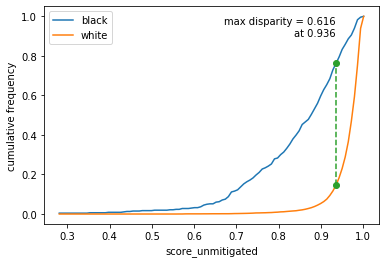

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import cumfreq

def compare_cdfs(data, A, num_bins=100):
    cdfs = {}
    assert len(np.unique(A)) == 2
    
    limits = ( min(data), max(data) )
    s = 0.5 * (limits[1] - limits[0]) / (num_bins - 1)
    limits = ( limits[0]-s, limits[1] + s)
    
    for a in np.unique(A):
        subset = data[A==a]
        
        cdfs[a] = cumfreq(subset, numbins=num_bins, defaultreallimits=limits)
        
    lower_limits = [v.lowerlimit for _, v in cdfs.items()]
    bin_sizes = [v.binsize for _,v in cdfs.items()]
    actual_num_bins = [v.cumcount.size for _,v in cdfs.items()]
    
    assert len(np.unique(lower_limits)) == 1
    assert len(np.unique(bin_sizes)) == 1
    assert np.all([num_bins==v.cumcount.size for _,v in cdfs.items()])
    
    xs = lower_limits[0] + np.linspace(0, bin_sizes[0]*num_bins, num_bins)
    
    disparities = np.zeros(num_bins)
    for i in range(num_bins):
        cdf_values = np.clip([v.cumcount[i]/len(data[A==k]) for k,v in cdfs.items()],0,1)
        disparities[i] = max(cdf_values)-min(cdf_values)  
    
    return xs, cdfs, disparities
    
    
def plot_and_compare_cdfs(data, A, num_bins=100, loc='best'):
    xs, cdfs, disparities = compare_cdfs(data, A, num_bins)
    
    for k, v in cdfs.items():
        plt.plot(xs, v.cumcount/len(data[A==k]), label=k)
    
    assert disparities.argmax().size == 1
    d_idx = disparities.argmax()
    
    xs_line = [xs[d_idx],xs[d_idx]]
    counts = [v.cumcount[d_idx]/len(data[A==k]) for k, v in cdfs.items()]
    ys_line = [min(counts), max(counts)]
    
    plt.plot(xs_line, ys_line, 'o--')
    disparity_label = "max disparity = {0:.3f}\nat {1:0.3f}".format(disparities[d_idx], xs[d_idx])
    plt.text(xs[d_idx], 1, disparity_label, ha="right", va="top")
    
    plt.xlabel(data.name)
    plt.ylabel("cumulative frequency")
    plt.legend(loc=loc)
    plt.show()

display(HTML('<span id="disparity_unmitigated">'))
plot_and_compare_cdfs(scores_unmitigated, A_test)
display(HTML('</span>'))

We see that the largest disparity of about 0.6 occurs at the threshold value 0.94: only 23% of black students, but 83% of white students are above this threshold.

## Mitigating Demographic Disparity with Grid Search

We next show how to mitigate the demographic disparity using the `GridSearch` algorithm of `fairlearn`. We will use this algorithm to obtain several models that achieve various trade-offs between accuracy (measured by AUC) and demographic disparity.

The `GridSearch` variant that we will use was developed for *classification* under demographic parity, but the experiments of
[Agarwal et al. (2018)](http://proceedings.mlr.press/v97/agarwal19d.html) show that it also performs well for *logistic regression* (viewed as the probability prediction) under demographic parity. While the resulting logistic models mitigate the demographic disparity, they might not be well calibrated (unlike unmitigated logistic models), so we use Platt's scaling for [calibration](https://scikit-learn.org/stable/modules/calibration.html). Note that Platt's scaling is a monotone transformation, and so it has no effect on the AUC values or the demographic disparity of the resulting model. However, it makes the predicted scores interpretable as probabilities.

`GridSearch` generates models corresponding to various Lagrange multiplier vectors of the underlying constraint optimization problem. We will compute 41 models on a grid of Lagrange multiplier vectors whose L1-norm is bounded by 10. For details on how the search works, refer to Section 3.4 of [Agarwal et. al (2018)](http://proceedings.mlr.press/v80/agarwal18a.html). The following cell may take a couple of minutes to run:

In [6]:
from fairlearn.reductions import GridSearch, DemographicParity
from sklearn.calibration import CalibratedClassifierCV

sweep = GridSearch(LogisticRegression(solver='liblinear', fit_intercept=True),
                   constraints=DemographicParity(),
                   grid_size=41,
                   grid_limit=10)

sweep.fit(X_train, y_train, sensitive_features=A_train)

calibrated_predictors = []
for result in sweep.all_results:
    calibrated = CalibratedClassifierCV(base_estimator=result.predictor, cv='prefit', method='sigmoid')
    calibrated.fit(X_train, y_train)
    calibrated_predictors.append(calibrated)

We next assess the accuracy and disparity of the obtained predictors in a scatter plot, with *x* axis showing the worst-case AUC among the two subpopulations (of black and white students) and *y* axis showing the demographic disparity. Ideal models would be in the bottom right.

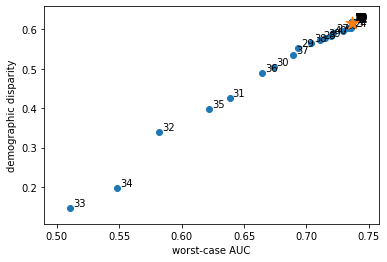

In [7]:
def auc_disparity_sweep_plot(predictors, names, marker='o', scale_size=1, zorder=-1):
    roc_auc = np.zeros(len(predictors))
    disparity = np.zeros(len(predictors))
    
    for i in range(len(predictors)):
        preds = predictors[i].predict_proba(X_test)[:,1]
        roc_auc[i] = group_roc_auc_score(y_test, preds, A_test).minimum
        _, _, dis = compare_cdfs(preds, A_test)
        disparity[i] = dis.max()
        
    plt.scatter(roc_auc, disparity,
                s=scale_size * plt.rcParams['lines.markersize'] ** 2, marker=marker, zorder=zorder)
    for i in range(len(roc_auc)):
        plt.annotate(names[i], (roc_auc[i], disparity[i]), xytext=(3,2), textcoords="offset points", zorder=zorder+1)
    plt.xlabel("worst-case AUC")
    plt.ylabel("demographic disparity")
    
auc_disparity_sweep_plot(calibrated_predictors, names=range(len(calibrated_predictors)))
auc_disparity_sweep_plot([unmitigated_predictor], names=[''], marker='*', zorder=1, scale_size=5)
plt.show()

Model 33 has the lowest disparity, but its worst-case AUC is essentially the same as that of a coin flip. The unmitigated model, marked as a star, has a good worst-case AUC, but large disparity. We examine models 35 and 36: their AUC values are well above 0.6 and they substantially reduce the demographic disparity compared with the unmitigated model:

,auc_model35,auc_model36,auc_unmitigated
black,0.649439,0.687297,0.747184
white,0.621983,0.664289,0.736673
overall,0.687396,0.732492,0.790532


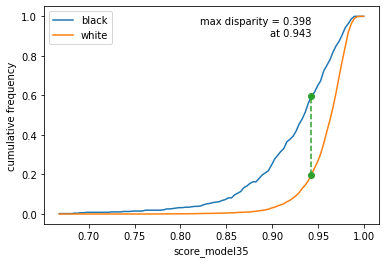

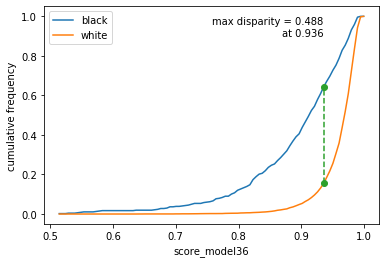

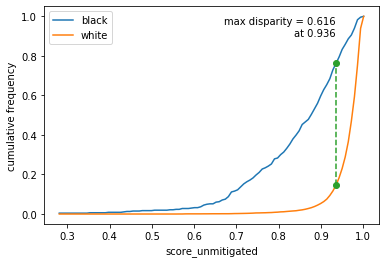

In [8]:
scores_model35 = pd.Series(calibrated_predictors[35].predict_proba(X_test)[:,1], name="score_model35")
scores_model36 = pd.Series(calibrated_predictors[36].predict_proba(X_test)[:,1], name="score_model36")

auc_model35 = group_metric_as_df("auc_model35",
                                 group_roc_auc_score(y_test, scores_model35, A_test))
auc_model36 = group_metric_as_df("auc_model36",
                                 group_roc_auc_score(y_test, scores_model36, A_test))

display(HTML('<span id="grid_search_comparison">'),
        pd.concat([auc_model35, auc_model36, auc_unmitigated], axis=1),
        HTML('</span>'))
plot_and_compare_cdfs(scores_model35, A_test)
plot_and_compare_cdfs(scores_model36, A_test)
plot_and_compare_cdfs(scores_unmitigated, A_test)

### Comparing Probabilistic Predictors using the Dashboard

Next, we compare the three predictors above (unmitigated, model 35 and model 36) using `FairlearnDashboard`. The dashboard currently does not evaluate the demographic disparity of probabilistic scores, but instead evaluates the disparity in mean predictions&mdash;in this case, this amounts to the difference between mean predictions for the white and black subpopulations. However, thanks to the calibration step, the disparity in mean predictions qualitatively agrees with the demographic disparity (albeit this is not always the case and in general they could go in opposite directions).

In [9]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features=A_test, sensitive_feature_names=['Race'],
                   y_true=y_test,
                   y_pred={"unmitigated": scores_unmitigated, "model35": scores_model35, "model36": scores_model36})

FairlearnWidget(value={'true_y': [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…

## Obtaining Low-Disparity Classifiers

In this section, we shift attention from the task of scoring and ranking students to the task of automatically classifying students, for example, in order to screen them for an interview or a deeper review of their application materials. Our goal is to obtain a _classifier_ that maximizes AUC while respecting demographic parity.

The outputs of a classifier are either 0 or 1, so it is possible to re-interpret the AUC of a classifier as the *balanced accuracy*, meaning the accuracy under the distribution re-weighted to have the same mass of positive and negative examples. Demographic disparity can also be interpreted as the difference between the rates at which the students of either race are classified as 1; we refer to this rate as the _selection rate_.

### Postprocessing

We first show how to obtain low-disparity classifiers by thresholding scores&mdash;such as the scores produced by unmitigated logistic regression&mdash;using the postprocessing algorithm of [Hardt et al. (2016)](https://arxiv.org/abs/1610.02413), implemented in the class  `ThresholdOptimizer`. This algorithm finds thresholds that optimize accuracy subject to the constraint that there be no demographic disparity on the training data. Since our goal here is to optimize _balanced_ accuracy rather than accuracy, we first re-balance the data by randomly subsampling positive examples, so they are equal in number to negative examples. We then pass this re-balanced data set to `ThresholdOptimizer`. Since the accuracy of a classifier on the re-balanced data set is in expectation equal to the AUC on the original data, `ThresholdOptimizer` now seeks to optimize our desired accuracy metric.

In [10]:
from fairlearn.postprocessing import ThresholdOptimizer

# We want to apply ThresholdOptimizer to the probabilities returned
# by the unmitigated logistic regression predictor. Since ThresholdOptimizer
# applies thresholding to the output of predict(), but LogisticRegression
# returns probabilities (of both classes) in predict_proba(), we need to
# use the following wrapper for LogisticRegression.

class LogisticRegressionAsRegression:
    def __init__(self, logistic_regression_estimator):
        self.logistic_regression_estimator = logistic_regression_estimator
    
    def fit(self, X, y):
        self.logistic_regression_estimator.fit(X, y)
    
    def predict(self, X):
        # use predict_proba to get real values instead of 0/1, select only prob for 1
        scores = self.logistic_regression_estimator.predict_proba(X)[:,1]
        return scores


balanced_index_pass0 = y_train[y_train==0].index 
balanced_index_pass1 = y_train[y_train==1].sample(n=balanced_index_pass0.size, random_state=0).index
balanced_index = balanced_index_pass0.union(balanced_index_pass1)

pp_estimator = ThresholdOptimizer(
    unconstrained_predictor=LogisticRegressionAsRegression(unmitigated_predictor),
    constraints="demographic_parity")

pp_estimator.fit(X_train.iloc[balanced_index,:], y_train.iloc[balanced_index],
                 sensitive_features=A_train.iloc[balanced_index])

We next evaluate AUC (balanced accuracy) and demographic disparity (disparity in selection rates) of the black and white students on the test data; note that we use the actual test data (not a re-balanced version, which we only used for training purposes).

In [11]:
from fairlearn.metrics import group_mean_prediction

scores_pp = pd.Series(pp_estimator.predict(X_test, sensitive_features=A_test), name="scores_post")
auc_pp = group_metric_as_df(
    "auc_post",
    group_roc_auc_score(y_test, scores_pp, A_test))
sel_pp = group_metric_as_df(
    "selection_post",
    group_mean_prediction(y_test, scores_pp, A_test))

pp_summary = pd.concat([auc_pp, sel_pp], axis=1)
pp_summary.loc['disparity']=(pp_summary.loc['white']-pp_summary.loc['black']).abs()
pp_summary.loc['disparity', pp_summary.columns.str.startswith('auc')]='-'

display(pp_summary)

,auc_post,selection_post
black,0.694143,0.557940
white,0.648677,0.460865
overall,0.640316,0.467565
disparity,-,0.097074


The original unmitigated scores have the demographic disparity around 0.6 (see [here](#disparity_unmitigated)). We see that `ThresholdOptimizer` dramatically reduces the disparity to around 0.1. At the same time, the AUC in each subpopulation is at or above 0.65, a moderate drop from the unmitigated values of 0.72 and 0.74 (see [here](#auc_unmitigated)). This is a more favorable trade-off than the one achieved by model 35 above, with the disparity of 0.4 and the worst-case AUC of around 0.62 (see [here](#grid_search_comparison)). However, note that `ThresholdOptimizer` is a classifier, and so it can only work as a crude ranker. Additionally, `ThresholdOptimizer` uses the sensitive feature (in this instance race) at the prediction time, by applying a different threshold to unmitigated scores depending on race. In some use cases, these two properties might be undesirable. We next show how to obtain a classifier that also seeks to achieve low demographic disparity, but without requiring access to the sensitive feature at the evaluation time.

*Note*: `ThresholdOptimizer` produces randomized predictions, so the AUC and selection rate of postprocessing will vary if you re-run the cell above. Also, while `ThresholdOptimizer` is guaranteed to achieve zero demographic disparity on its training data, this does not mean it will achieve zero demographic disparity on the test data for several reasons: (1) the training data is balanced whereas test data is not, so test data comes from a different distribution than training data; (2) even if training and test data were coming from the same distribution, there would be some differences due to finite sample sizes.

### Exponentiated Gradient

`ExponentiatedGradient` also seeks to find a classifier that optimizes accuracy while placing a constraint on the demographic disparity. However, it operates as a *reduction* to standard classification, taking any estimator as a black box. During its run it repeatedly re-fits the estimator on variously reweighted training data and eventually produces a randomized classifier of the same type as the provided black-box estimator. This means that if the black box does not have access to the sensitive feature, neither will the predictor fitted by `ExponentiatedGradient`.

We next train two classifiers via `ExponentiatedGradient`. Both use `LogisticRegression` as a black box. However, one has only access to the original features (**X_train** and **X_test**), whereas the other one also has access to the sensitive features, which we include in the extended feature set (**XA_train** and **XA_test**). Both classifiers optimize AUC subject to the constraint that demographic disparity on training data is at most 0.01. We also set the convergence parameter `nu` to `1e-6` to optimize to numerical precision (the default is to optimize to statistical precision, which we override here).

In [12]:
from fairlearn.reductions import ExponentiatedGradient

XA_train = pd.concat([X_train, A_train=='black'], axis=1).astype(float)
XA_test = pd.concat([X_test, A_test=='black'], axis=1).astype(float)

expgrad_X = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=0.01,
    nu=1e-6)
expgrad_XA = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=0.01,
    nu=1e-6)

expgrad_X.fit(
    X_train.iloc[balanced_index,:],
    y_train.iloc[balanced_index],
    sensitive_features=A_train.iloc[balanced_index])
expgrad_XA.fit(
    XA_train.iloc[balanced_index,:],
    y_train.iloc[balanced_index],
    sensitive_features=A_train.iloc[balanced_index])

In [13]:
scores_expgrad_X = pd.Series(expgrad_X.predict(X_test), name="scores_expgrad_X")
scores_expgrad_XA = pd.Series(expgrad_XA.predict(XA_test), name="scores_expgrad_XA")

auc_expgrad_X = group_metric_as_df(
    "auc_expgrad_X",
    group_roc_auc_score(y_test, scores_expgrad_X, A_test))
sel_expgrad_X = group_metric_as_df(
    "selection_expgrad_X",
    group_mean_prediction(y_test, scores_expgrad_X, A_test))
auc_expgrad_XA = group_metric_as_df(
    "auc_expgrad_XA",
    group_roc_auc_score(y_test, scores_expgrad_XA, A_test))
sel_expgrad_XA = group_metric_as_df(
    "selection_expgrad_XA",
    group_mean_prediction(y_test, scores_expgrad_XA, A_test))

classifier_summary = pd.concat([auc_pp, sel_pp, auc_expgrad_X, sel_expgrad_X, auc_expgrad_XA, sel_expgrad_XA], axis=1)
classifier_summary.loc['disparity']=(classifier_summary.loc['white']-classifier_summary.loc['black']).abs()
classifier_summary.loc['disparity', classifier_summary.columns.str.startswith('auc')]='-'
display(classifier_summary)

,auc_post,selection_post,auc_expgrad_X,selection_expgrad_X,auc_expgrad_XA,selection_expgrad_XA
black,0.694143,0.557940,0.508877,0.461373,0.623572,0.686695
white,0.648677,0.460865,0.516347,0.518136,0.682123,0.632517
overall,0.640316,0.467565,0.521053,0.514218,0.650699,0.636256
disparity,-,0.097074,-,0.056762,-,0.054179


We see that exponentiated gradient variants generally achieve lower disparity on this data than `ThresholdOptimizer`. Without access to the sensitive feature at the test time, this comes at the cost of bringing the AUC essentially to that of a random coin toss (AUC of **expgrad_X** is close to 0.5). With access to the sensitive feature, the overall AUC is comparable to that achieved by `ThresholdOptimizer`, but `ThresholdOptimizer` achieves a better worst-case AUC across the two population. 

*Note*: `ExponentiatedGradient` produces randomized predictions (similarly to `ThresholdOptimizer`), so the AUC and selection rate will vary if you re-run the cell above. Also, because of a mismatch between the training and test distributions and because of finite samples, we do not expect `ExponentiatedGradient` to achieve test disparity equal to 0.01.

We next show that if we are willing to tolerate a larger demographic disparity, it is possible to achieve non-trivial AUC values even without access to the sensitive feature. We run `ExponentiatedGradient` with the bound on the training disparity equal to 0.3:

In [14]:
expgrad_X_alt = ExponentiatedGradient(
    LogisticRegression(solver='liblinear', fit_intercept=True),
    constraints=DemographicParity(),
    eps=0.3, # This has changed from 0.01 in the above examples
    nu=1e-6)

expgrad_X_alt.fit(
    X_train.iloc[balanced_index,:],
    y_train.iloc[balanced_index],
    sensitive_features=A_train.iloc[balanced_index])

scores_expgrad_X_alt = pd.Series(
    expgrad_X_alt.predict(X_test), name="scores_expgrad_X_alt")

auc_expgrad_X_alt = group_metric_as_df(
    "auc_expgrad_X_alt",
    group_roc_auc_score(y_test, scores_expgrad_X_alt, A_test))
sel_expgrad_X_alt = group_metric_as_df(
    "selection_expgrad_X_alt",
    group_mean_prediction(y_test, scores_expgrad_X_alt, A_test))

auc_expgrad_X_alt.loc['disparity'] = '-'
sel_expgrad_X_alt.loc['disparity'] = (sel_expgrad_X_alt.loc['white'] - sel_expgrad_X_alt.loc['black']).abs()

display(pd.concat([auc_expgrad_X_alt, sel_expgrad_X_alt], axis=1))

,auc_expgrad_X_alt,selection_expgrad_X_alt
black,0.558238,0.328326
white,0.60504,0.666879
overall,0.632147,0.643513
disparity,-,0.338553


### Comparing Classifiers using the Dashboard

We finish this section by comparing the four predictors above using `FairlearnDashboard`:

In [15]:
FairlearnDashboard(sensitive_features=A_test, sensitive_feature_names=['Race'],
                   y_true=y_test,
                   y_pred={"postprocessing": scores_pp,
                           "expgrad_X": scores_expgrad_X,
                           "expgrad_X_alt": scores_expgrad_X_alt,
                           "expgrad_XA": scores_expgrad_XA})

FairlearnWidget(value={'true_y': [1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1…